In [52]:
import sys
import matplotlib.pyplot as plt
import math
import numpy as np
import random as rng

import imutils

import cv2
import pytesseract
import re
from pyzbar import pyzbar

# QR

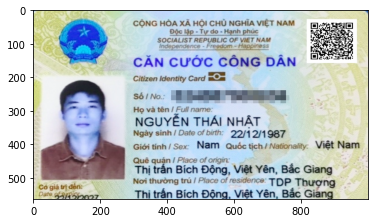

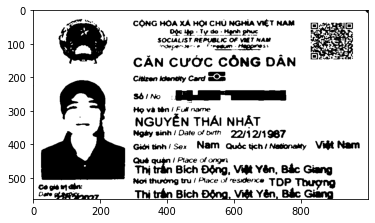

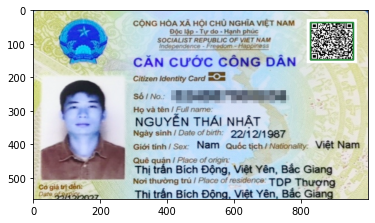

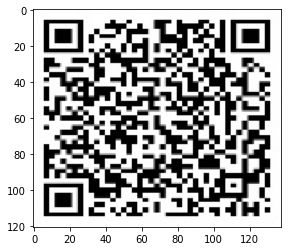

{'new_ID': '001044009271',
 'old_ID': '123456789',
 'name': 'Nguyễn Thành Bảo',
 'date_of_birth': '01/12/1944',
 'gender': 'Nam',
 'address': 'Tổ 3, Yên Hòa, Cầu Giấy, Hà Nội',
 'create_date': '24/06/2021'}

In [59]:
imagePath='data/cccd_trc.jpg'
image = cv2.imread(imagePath)
def extract_qr(image):
    img = image.copy()
    plt.imshow(image,)
    plt.show()
    kernel_size= 25
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (H, W) = gray.shape

    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 127,255, cv2.THRESH_OTSU)[1]
    plt.imshow( thresh, cmap = 'gray')
    plt.show()

    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(contours)


    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        percentWidth = w / float(W)
        percentHeight = h / float(H)
        percent = w / h

        if percent >0.8 and percent < 1.2 and percentHeight > 0.1 and percentHeight < 0.3 :         
            QR_Box = img[y-5:y + h+5, x-5:x + w+5]

            color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
            cv2.rectangle(image,(int(x),int(y)),(int(x+w),int(y+h)), color,thickness=4)

    plt.imshow(image)
    plt.show()
    plt.imshow(QR_Box)
    plt.show()

    qrtext=pyzbar.decode(QR_Box)[0].data.decode('utf8')
    info={}
    if qrtext!= None:
        new_num,old_num,full_name,date_of_birth,sex,address,create_date=qrtext.split('|')
        date_of_birth=date_of_birth[0:2]+"/"+date_of_birth[2:4]+"/"+date_of_birth[4:]
        create_date=create_date[0:2]+"/"+create_date[2:4]+"/"+create_date[4:]
        info["new_ID"]=new_num
        info["old_ID"]=old_num
        info["name"]=full_name
        info["date_of_birth"] = date_of_birth
        info["gender"] = sex
        info["address"] = address
        info["create_date"]=create_date
    return info
imagePath='data/cccd_trc.jpg'
image_back = cv2.imread(imagePath)
extract_qr(image_back)

# Info

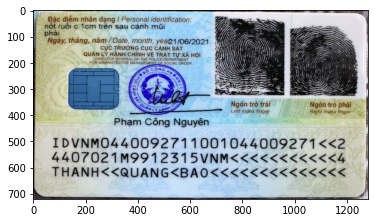

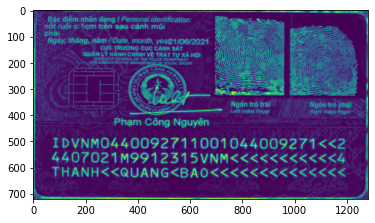

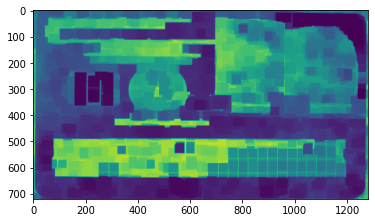

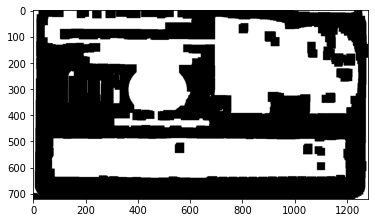

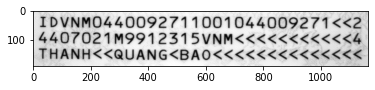

IDVNM0440092711001044009271<<2
4407021M9912315VNM<<<<<<<<<<<4
THANH<<QUANG<BA0<<<<<<<<<<<<<<¢



{'id': '001044009271',
 'date_of_birth': '440702',
 'date_of_expiry': '991231',
 'gender': 'M',
 'name': 'THANH QUANG BAO'}

In [26]:
def extract_mrz_info(image, kernel_size = 30):
    image = cv2.resize(image, (1280, 720))

    plt.imshow(image, cmap='gray')
    plt.show()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (H, W) = gray.shape

    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
    plt.imshow( blackhat)
    plt.show()

    grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    grad = np.absolute(grad)
    (minVal, maxVal) = (np.min(grad), np.max(grad))
    grad = (grad - minVal) / (maxVal - minVal)
    grad = (grad * 255).astype("uint8")
    grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
    plt.imshow( grad)
    plt.show()

    thresh = cv2.threshold(grad, 0, 255, cv2.THRESH_OTSU)[1]
    plt.imshow(thresh, cmap='gray')
    plt.show()

    # find contour
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                          cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    mrzBox = None
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        percentWidth = w / float(W)
        percentHeight = h / float(H)
        percent = w/h

        if percentWidth > 0.6 and percentHeight > 0.05 and percent > 4:
            mrzBox = (x, y, w, h)
            break

    if mrzBox is None:
        print("Không tìm thấy MRZ")
        return None

    (x, y, w, h) = mrzBox
    # extract the padded MRZ from the image
    mrz = gray[y-20:y+h+20, x-20:x+w+20]

    plt.imshow(mrz, cmap='gray')
    plt.show()

    mrzText = pytesseract.image_to_string(mrz).replace(' ','')
    print(mrzText)

    # extract info
    info={}
    txt = mrzText.split('\n')
    info['id']=txt[0][-15:-3]
    dates = re.findall(r'[+\d]{6}',txt[1])
    info['date_of_birth'] = dates[0]
    info['date_of_expiry']=dates[1]
    info['gender']= txt[1][7] 
    info['name'] = " ".join(x for x in re.findall(r'[+A-Z]+',txt[2].replace('0','O'))[:3])
#     print(info)
    return info


imagePath='data/Can cuoc_sau.jpg'
image_back = cv2.imread(imagePath)
extract_mrz_info(image_back)

# Fingerprint

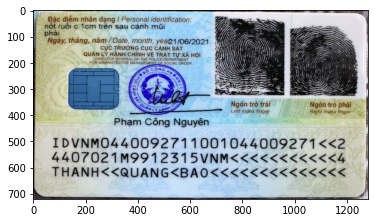

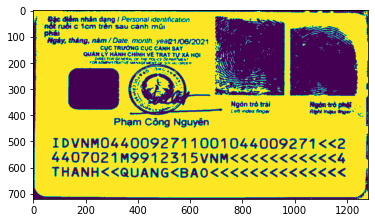

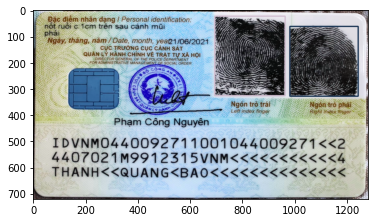

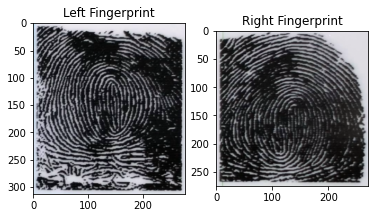

In [27]:
def extract_fingerprint(image):
    image = cv2.resize(image, (1280, 720))
    img= image.copy()
    plt.imshow(image,)
    plt.show()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (H, W) = gray.shape
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 127,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    plt.imshow( thresh)
    plt.show()

    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(contours)
    Box = []
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        percentWidth = w / float(W)
        percentHeight = h / float(H)
        percent = w / h

        if percent >0.8 and percent < 1.2 and percentWidth > 0.15 and percentHeight> 0.25  :       
            Box.append((x, y, w, h))
            color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
            cv2.rectangle(image,(int(x),int(y)),(int(x+w),int(y+h)), color,thickness=3)
    plt.imshow(image)
    plt.show()

    (x1, y1, w1, h1) = Box[0]
    (x2, y2, w2, h2) = Box[1]
    if x1 >x2:
        left_finger = img[y2-5:y2+h2+5, x2-5:x2+w2+5]
        right_finger = img[y1-5:y1+h1+5, x1-5:x1+w1+5]
    else:
        right_finger = image[y2-5:y2+h2+5, x2-5:x2+w2+5]
        left_finger = img[y1-5:y1+h1+5, x1-5:x1+w1+5]
        
    fig = plt.figure(figsize=(6,10))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(left_finger)
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(right_finger)
    ax1.title.set_text('Left Fingerprint')
    ax2.title.set_text('Right Fingerprint')
    return left_finger , right_finger
figsize=(5,4)
imagePath='data/Can cuoc_sau.jpg'
image_back = cv2.imread(imagePath)
left_finger , right_finger = extract_fingerprint(image_back)